In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl


In [2]:
df = pd.read_excel("222IS2901_DAwR_P_FinalProject_Le Thi My Hanh.xlsx")

In [3]:
print("Number of rows in training dataset",df.shape)

Number of rows in training dataset (10683, 11)


In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
#checking for null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
#kiểm tra các cột có giá trị null
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())

     Route Total_Stops
9039   NaN         NaN


In [7]:
#loại bỏ các giá trị null
df.dropna(inplace=True)

In [8]:
#Chọn các hàng trùng lặp ngoại trừ lần xuất hiện đầu tiên dựa trên tất cả các cột
duplicateRowsDF = df[df.duplicated()]
print("Total Duplicate Rows except first occurrence based on all columns are :")
duplicateRowsDF.shape

Total Duplicate Rows except first occurrence based on all columns are :


(220, 11)

In [9]:
#Loại bỏ các hàng trùng lặp
df.drop_duplicates(keep='first',inplace=True)

### DATA CLEANING  

In [10]:
print("Train set:\n",df["Additional_Info"].value_counts())

Train set:
 No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64


In [11]:
# thay thế giá trị lặp lại trong tập train
df["Additional_Info"] = df["Additional_Info"].replace({'No Info': 'No info'})

In [12]:
df["Destination"].value_counts()


Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [13]:
#gán các giá trị bằng số, chuyển đổi kiểu
df.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df["Total_Stops"] = df["Total_Stops"].astype(int)

In [14]:
df["Total_Stops"].dtype

dtype('int32')

Airline: tên hãng hàng không

Date_of_Journey: ngày khởi hành

Source: điểm khởi hành

Destination: điểm đến

Route: Lộ trình chuyến bay (bao gồm cả điểm dừng)

Dep_Time: Thời gian khởi hành

Arrival_Time: thời gian cất cánh

Duration: Tổng thời gian bay

Total_Stops: Tổng điểm dừng

Additional_Info:  Thông tin thêm về chuyến bay

Price: Một vấn đề hồi quy trong đó thời gian,  nơi khởi hành, điểm đến, ngày bay và tuyến đường được cung cấp

In [15]:
df["Route"].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1536
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

In [16]:
df["Source"].value_counts()

Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [17]:
# feature engineering on Date_of_Journey column
# Extract day and month of journey from the above column in both train and test dataset

df["isWeekend"] = ((pd.to_datetime(df["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df["Day_of_Week"] = pd.to_datetime(df["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df["Day_Of_Journey"] = pd.to_datetime(df["Date_of_Journey"], format = '%d/%m/%Y').dt.day
df["Month_of_Journey"] = pd.to_datetime(df["Date_of_Journey"], format = '%d/%m/%Y').dt.month


In [18]:
# Drop original feature from train and test dataset 
df.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)


In [19]:
# xử lý cột duration
duration = list(df["Duration"])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  
dur_seconds = []
for i in range(len(duration)) :
    dur_minutes.append(int(duration[i].split()[0][:-1])*60 + int(duration[i].split()[1][:-1]))
    dur_seconds.append(int(duration[i].split()[0][:-1])*60*60 + int(duration[i].split()[1][:-1])*60)
df["Duration_minutes"] = dur_minutes
df.drop(["Duration"], axis=1, inplace = True)

In [20]:
#Cleaning Departure and Arrival Times
df['Depart_Time_Hour'] = pd.to_datetime(df.Dep_Time).dt.hour
df['Depart_Time_Minutes'] = pd.to_datetime(df.Dep_Time).dt.minute
df.drop(labels = 'Dep_Time', axis = 1, inplace = True)
df['Arr_Time_Hour'] = pd.to_datetime(df.Arrival_Time).dt.hour
df['Arr_Time_Minutes'] = pd.to_datetime(df.Arrival_Time).dt.minute
df.drop(labels = 'Arrival_Time', axis = 1, inplace = True)


### EDA

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64


<AxesSubplot:>

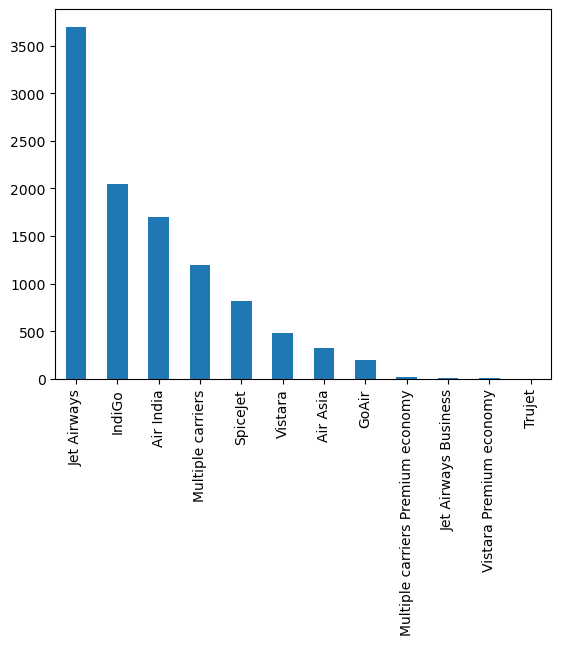

In [21]:

carrier_count = df["Airline"].value_counts()
print(carrier_count)
df['Airline'].value_counts().plot(kind='bar')

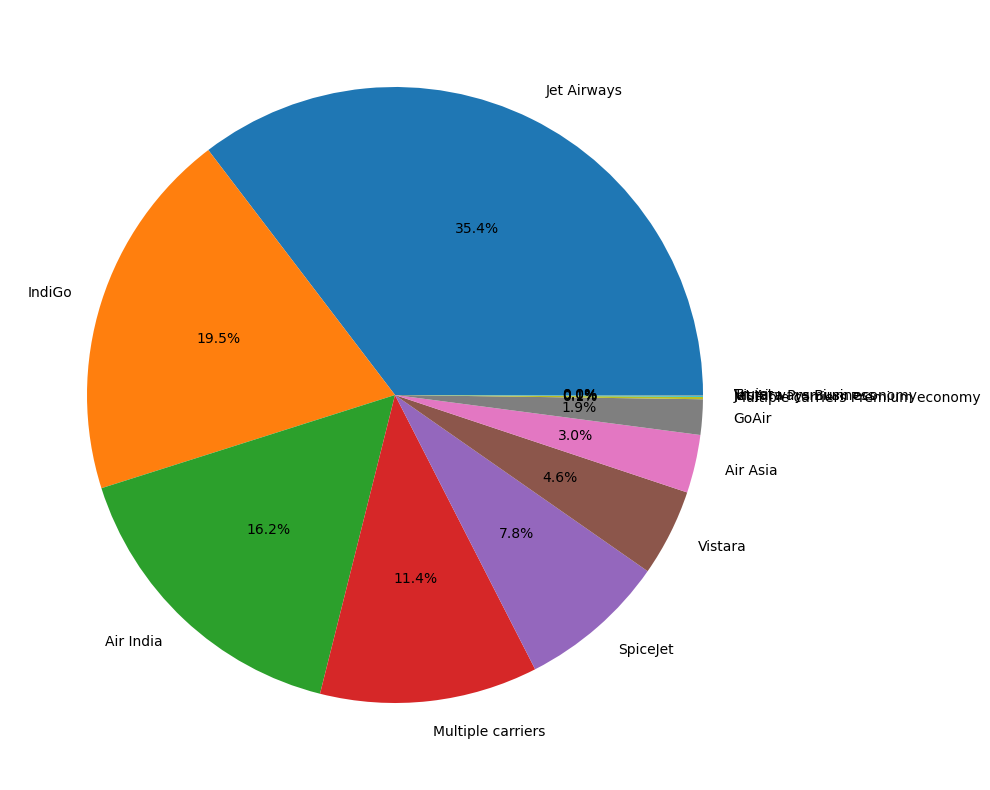

In [22]:
#Percentage of airlines in the dataset with name of the airlines by pie chart
plt.figure(figsize=(10,10))
plt.pie(carrier_count, labels=carrier_count.index, autopct='%1.1f%%')
plt.show()


*Nhận xét biểu hồ*

*Jet Airways có số lượng chuyến bay cao nhất, tức là đây là chuyến bay ưa thích của khách du lịch*

Bốn chuyến bay cuối cùng có số lượng chuyens bay dưới 100, cụ thể là:
 Multiple carriers Premium economy      13

Jet Airways Business                    6

Vistara Premium economy                 3

Trujet                                  1

4 hãng này cóthể được gộp thành một danh mục "Other flights" để cải thiện độ chính xác của mô hình

In [23]:
#Merge Multiple carriers Premium economy Jet Airways Business, Vistara Premium economy, Trujet into Others in the Airline column
df["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)


In [24]:
# kiểm tra các hành trình 
df["Route"].unique()

array(['BLR → DEL', 'CCU → IXR → BBI → BLR', 'DEL → LKO → BOM → COK',
       'CCU → NAG → BLR', 'BLR → NAG → DEL', 'CCU → BLR',
       'BLR → BOM → DEL', 'DEL → BOM → COK', 'DEL → BLR → COK',
       'MAA → CCU', 'CCU → BOM → BLR', 'DEL → AMD → BOM → COK',
       'DEL → PNQ → COK', 'DEL → CCU → BOM → COK', 'BLR → COK → DEL',
       'DEL → IDR → BOM → COK', 'DEL → LKO → COK',
       'CCU → GAU → DEL → BLR', 'DEL → NAG → BOM → COK',
       'CCU → MAA → BLR', 'DEL → HYD → COK', 'CCU → HYD → BLR',
       'DEL → COK', 'CCU → DEL → BLR', 'BLR → BOM → AMD → DEL',
       'BOM → DEL → HYD', 'DEL → MAA → COK', 'BOM → HYD',
       'DEL → BHO → BOM → COK', 'DEL → JAI → BOM → COK',
       'DEL → ATQ → BOM → COK', 'DEL → JDH → BOM → COK',
       'CCU → BBI → BOM → BLR', 'BLR → MAA → DEL',
       'DEL → GOI → BOM → COK', 'DEL → BDQ → BOM → COK',
       'CCU → JAI → BOM → BLR', 'CCU → BBI → BLR', 'BLR → HYD → DEL',
       'DEL → TRV → COK', 'CCU → IXR → DEL → BLR',
       'DEL → IXU → BOM → COK', 'CCU 

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

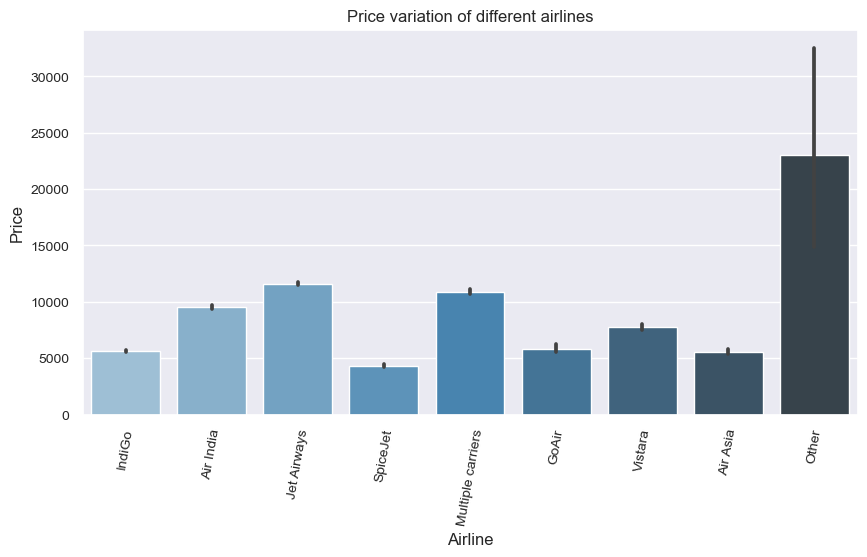

In [25]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,5)) 
sns.barplot(x="Airline", y="Price", data=df, palette="Blues_d")
plt.title('Price variation of different airlines')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)



Text(0.5, 1.0, 'Total stops')

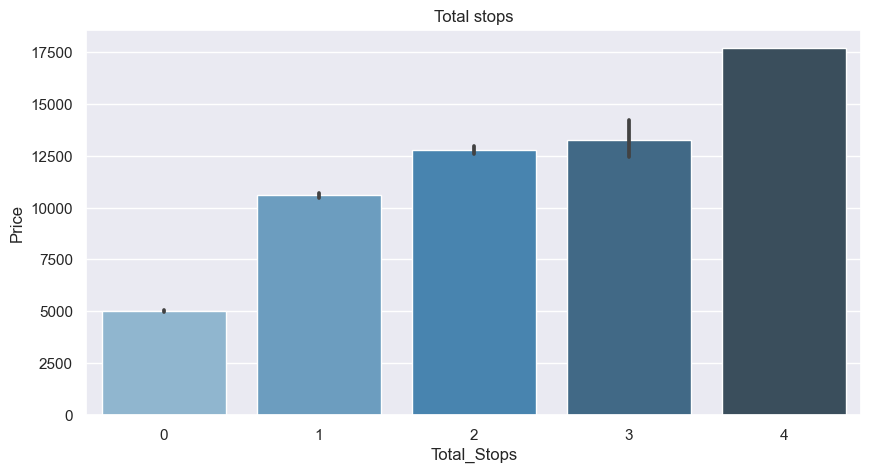

In [26]:

from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="Total_Stops", y="Price", data=df, palette="Blues_d")
plt.title('Total stops')

*Nhận xé từ biểu đồ-*

Điểm dừng càng nhiều thì giá vé càng cao

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

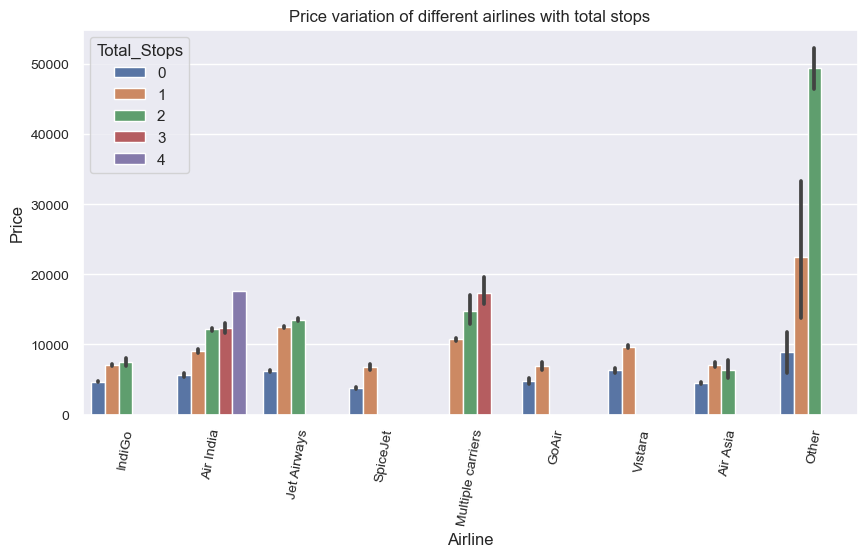

In [27]:
#price and total stops by airline
sns.set(style="darkgrid")
figure(figsize=(10,5))
sns.barplot(x="Airline", y="Price", hue="Total_Stops", data=df)
plt.title('Price variation of different airlines with total stops')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)


*Nhận xét: -*
Giá vé của Jet Airways là đắt nhất

No info                         8185
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64


<AxesSubplot:>

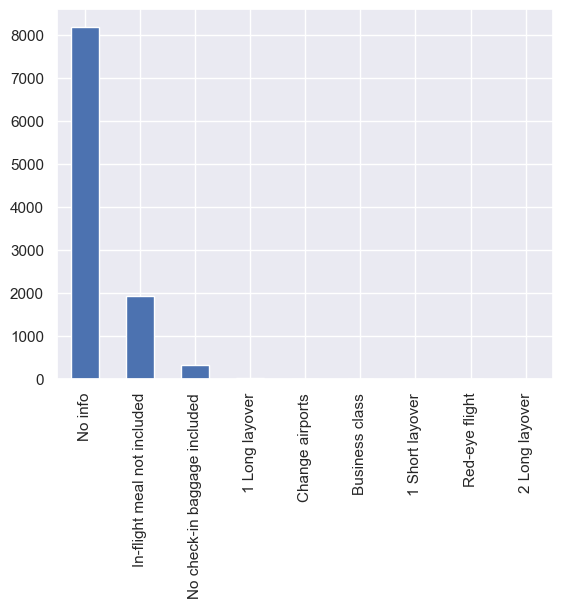

In [28]:
Additional_Info= df["Additional_Info"].value_counts()
print(Additional_Info)
df['Additional_Info'].value_counts().plot(kind='bar')

Từ biểu đồ hộp giữa giá của chuyến bay và hãng hàng không có thể rút ra kết luận rằng Jet Airways có nhiều outliner nhất về feature "Price".

Từ biểu đồ hình hộp giữa Price và Scource/nơi bắt đầu,có thể thấy rằng Banglore là địa điểm  có nhiều outlier nhất trong khi Chennai có ít nhất.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

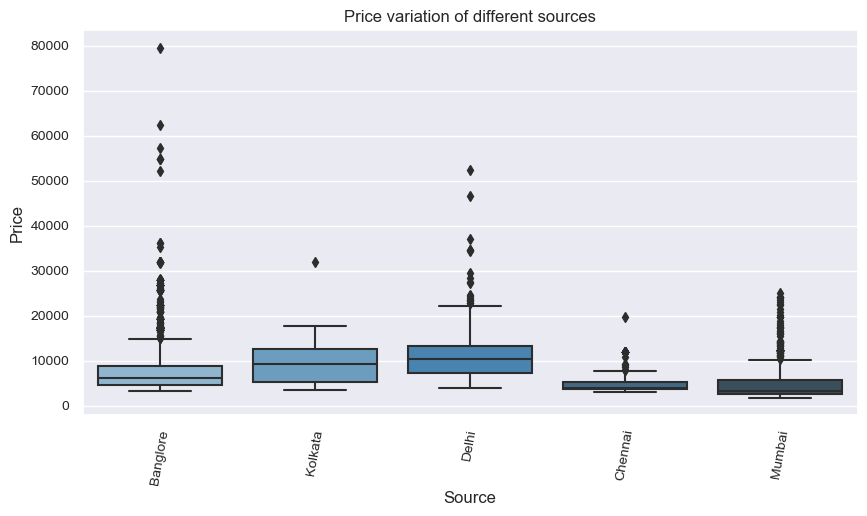

In [29]:
#source and price by boxplot
sns.set(style="darkgrid")
figure(figsize=(10,5))
sns.boxplot(x="Source", y="Price", data=df, palette="Blues_d")
plt.title('Price variation of different sources')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)



(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

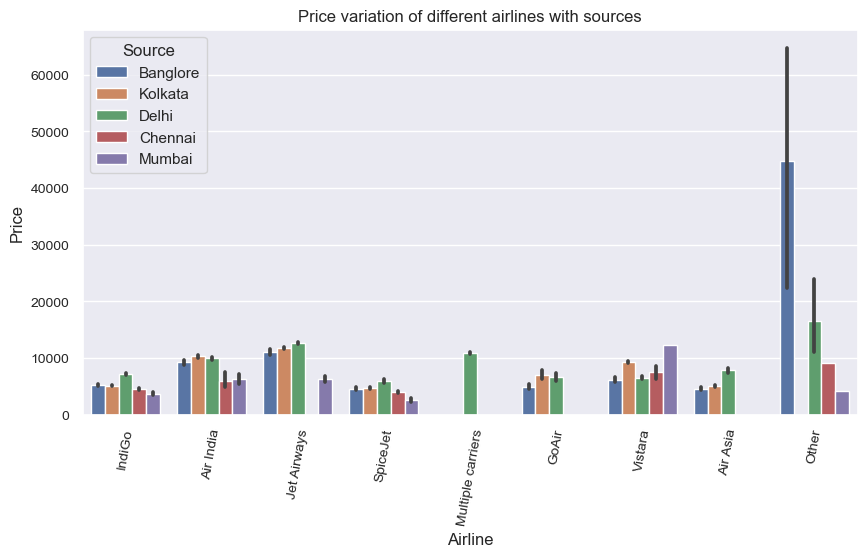

In [30]:
#source and price bay airline
sns.set(style="darkgrid")
figure(figsize=(10,5))
sns.barplot(x="Airline", y="Price", hue="Source", data=df)
plt.title('Price variation of different airlines with sources')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)


In [31]:
#combine delhi and new delhi
df["Destination"] = df["Destination"].replace({'New Delhi': 'Delhi'})


(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

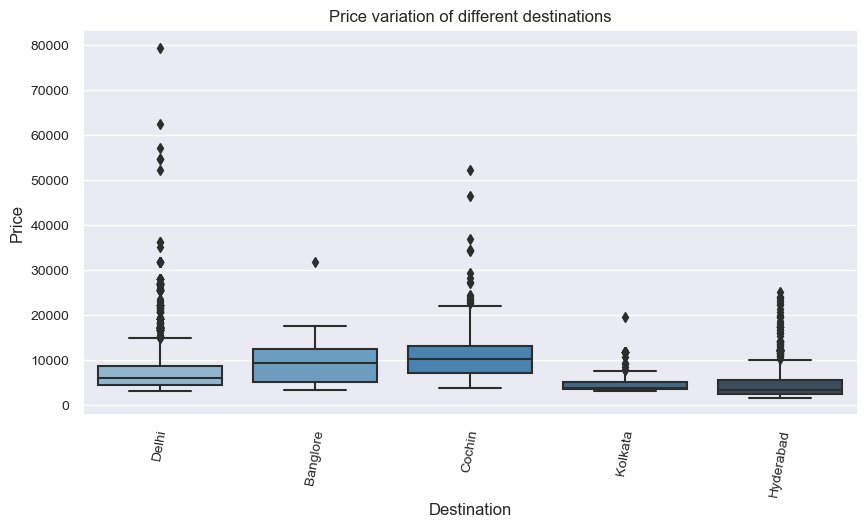

In [32]:
# Plotting Box plot for Price vs Destination with bule
plt.figure(figsize=(10,5))
sns.boxplot(x="Destination", y="Price", data=df, palette="Blues_d")
plt.title('Price variation of different destinations')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)



New Delhi có nhiều ouliers nhấ và Kolkata ít nhất. 
Phạm vi giá vé máy bay ở Delhi & New Delhi là tối đa, điều này có thể là do: Giá nhiên liệu máy bay ở Delhi đã tăng 26,4% trong năm 2018, đây cũng là Thủ đô Quốc gia, trụ sở chính trị của quyền lực và được nhiều người ghé thăm nơi dành cho các kỳ nghỉ (tương tự cho bangalore & cochin)
Lý do tương tự có thể được đưa ra cho phạm vi giá cao hơn ở delhi là nguồn của chuyến bay.

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


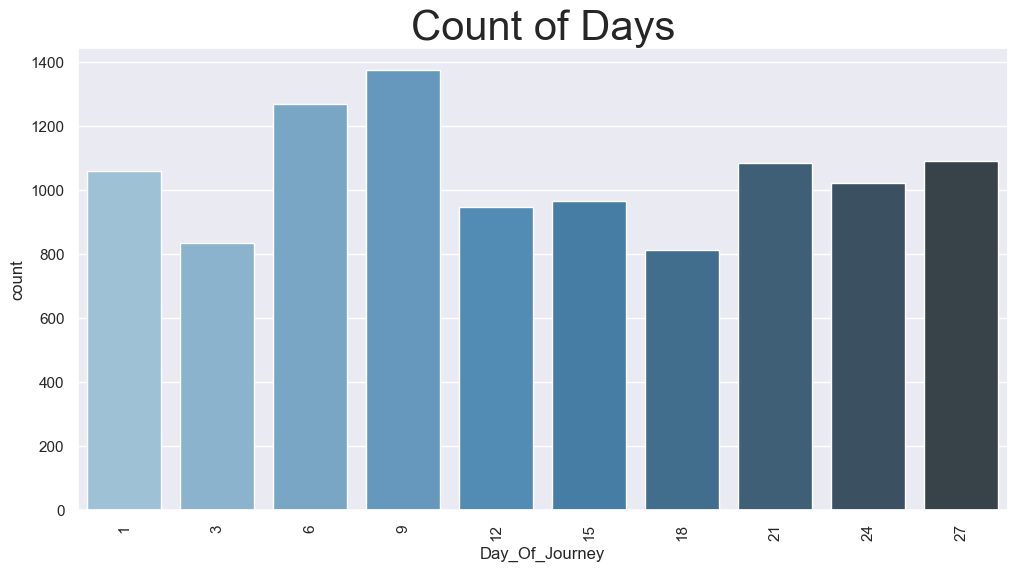

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(df['Day_Of_Journey'], palette='Blues_d')
plt.title('Count of Days', size=30)
plt.xticks(rotation=90)
plt.show()

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


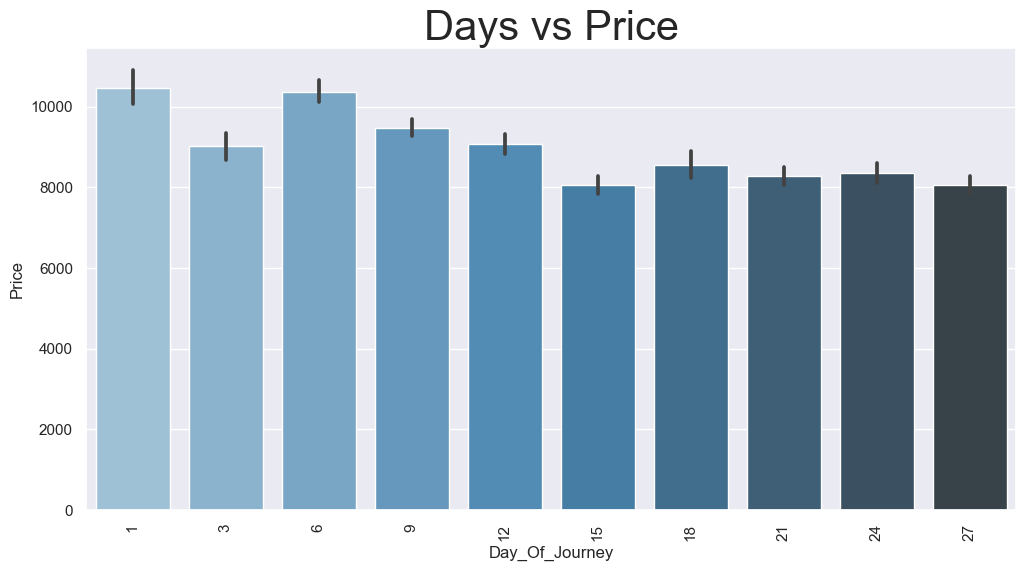

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(df['Day_Of_Journey'], df['Price'], palette='Blues_d')
plt.title('Days vs Price', size=30)
plt.xticks(rotation=90)
plt.show()

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


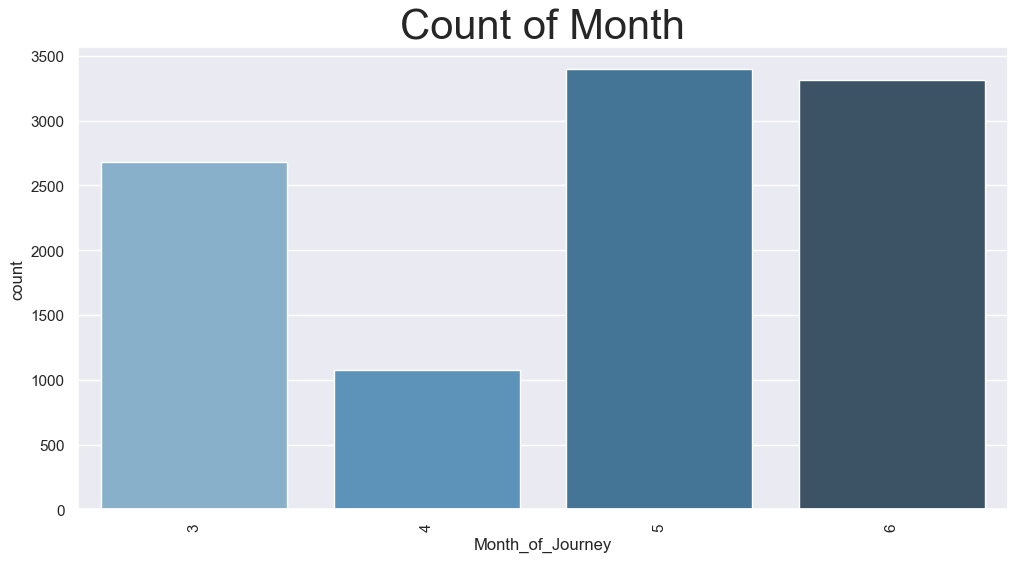

In [35]:
#visualize count of flights by month
plt.figure(figsize=(12,6))
sns.countplot(df['Month_of_Journey'], palette='Blues_d')
plt.title('Count of Month', size=30)
plt.xticks(rotation=90)
plt.show()


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

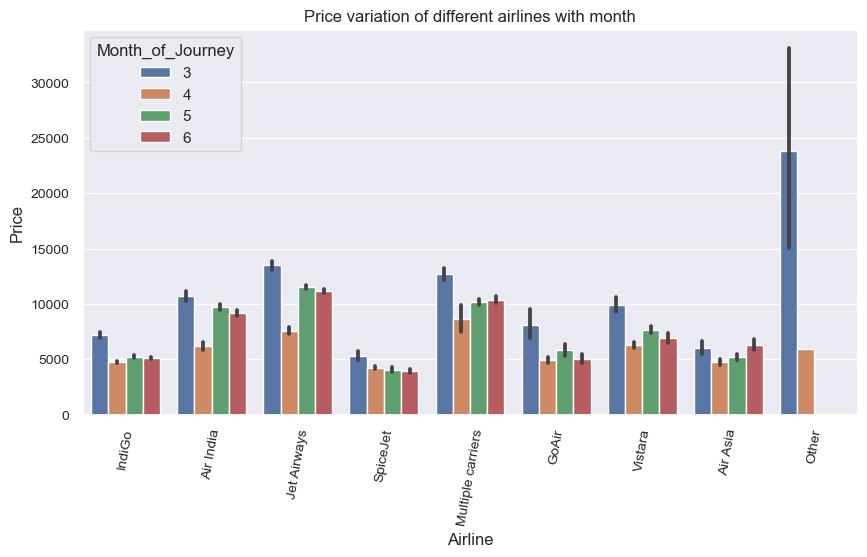

In [36]:
#month and price by airline
sns.set(style="darkgrid")
figure(figsize=(10,5))
sns.barplot(x="Airline", y="Price", hue="Month_of_Journey", data=df)
plt.title('Price variation of different airlines with month')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)


In [37]:
#count of flights per month
top_month=df.Month_of_Journey.value_counts().head(10)
top_month

5    3395
6    3311
3    2678
4    1078
Name: Month_of_Journey, dtype: int64

Có thể thấy tháng 5 là tháng các chuyến bay được khai thác tối đa nhất. Tuy nhiên tháng 3 lại là tháng giá vé máy bay cao nhất. 

tháng 5 được khai thác nhiều có thể là do: Kỳ nghỉ hè vào tháng 5 của các trường học/cao đẳng, do đó hầu hết các gia đình cũng thường đi nghỉ vào khoảng thời gian này.

Giá vé cao bất chợt vào tháng 3 có thể là do mới bắt đầu vào mùa hè, thời tiết không nắng gắt và có hoa nở. Ngoài ra có thể do tâm lý khách hàng muốn đặt trước tầm 2-3 tháng trước lịch trình đã dự kiến, dẫn đến nhu cầu cao hơn và giá vé cao hơn vào tháng 3. 

Số lượng chuyến bay thấp nhất vào tháng 4, có thể là do: Các trường học, cao đẳng tổ chức kỳ thi cuối kỳ vào khoảng thời gian này, các văn phòng hầu hết bận rộn vào tháng 4 vì là cuối Quý 1, bên cạnh đó đây cũng là tháng có thời tiết khắc nghiệt nhất. 

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


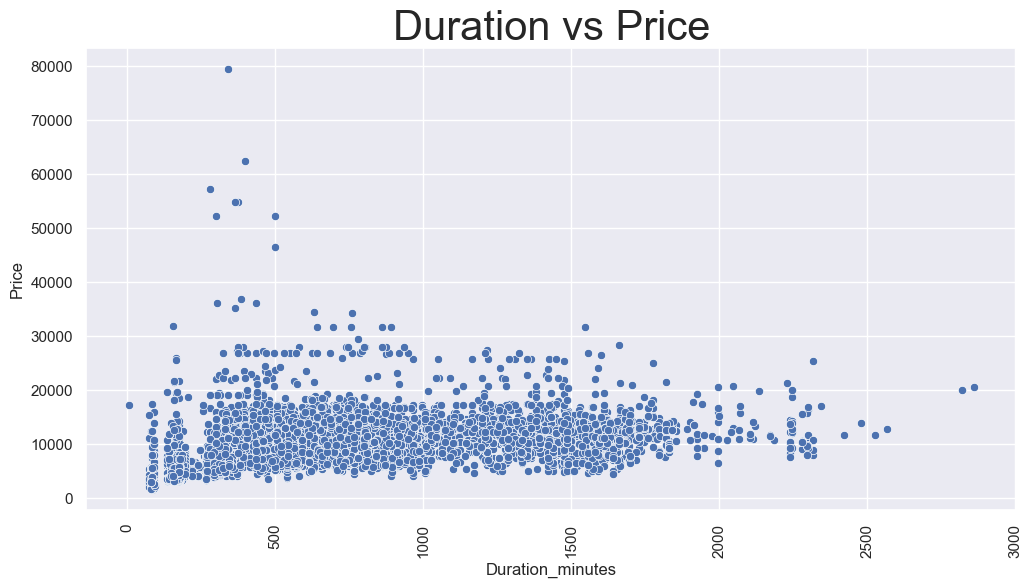

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(df['Duration_minutes'], df['Price'], palette='Blues')
plt.title('Duration vs Price', size=30)
plt.xticks(rotation=90)
plt.show()

Chúng tôi biết rằng thời lượng (hoặc khoảng cách) đóng vai trò chính trong việc ảnh hưởng đến giá vé máy bay nhưng chúng tôi không thấy mô hình nào như vậy ở đây, vì phải có những yếu tố quan trọng khác ảnh hưởng đến giá vé máy bay như loại hãng hàng không, điểm đến của chuyến bay, ngày hành trình của hành trình. chuyến bay cao hơn nếu va chạm với ngày lễ

Vì chuyến bay thẳng/thẳng chỉ tính giá vé của một chuyến bay cho một chuyến đi, giá vé trung bình của nó là thấp nhất. Như không. số điểm dừng/dừng tăng, giá vé tăng chiếm tỷ lệ không. của các chuyến bay và do các tài nguyên khác được sử dụng hết cho cùng.

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


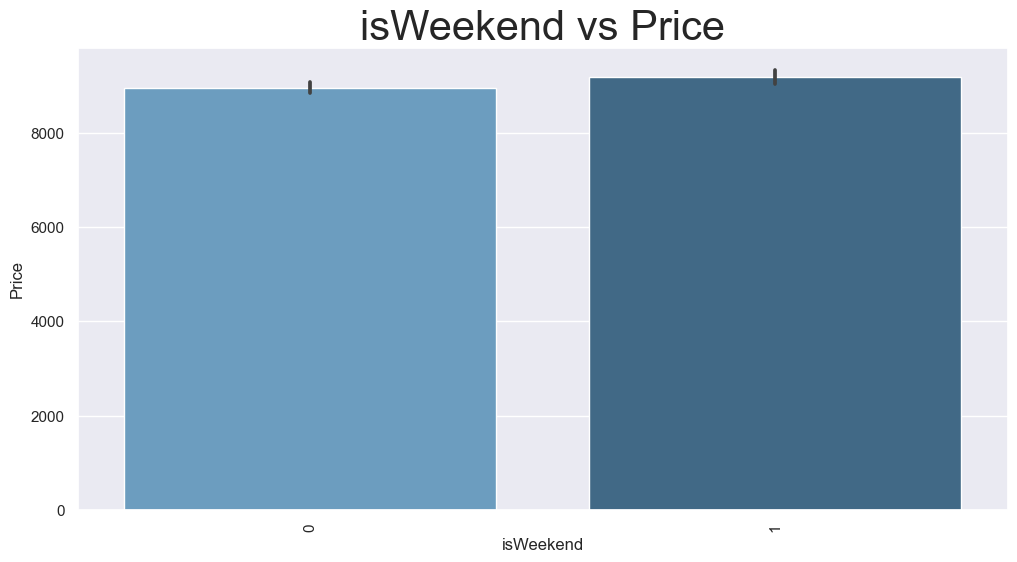

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(df['isWeekend'], df['Price'], palette='Blues_d')
plt.title('isWeekend vs Price', size=30)
plt.xticks(rotation=90)
plt.show()

In [40]:
#Top 10 flights with the highest fare
top_10=df.sort_values(by='Price', ascending=False).head(10)
top_10

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
2924,Other,Banglore,Delhi,BLR → BOM → DEL,1,Business class,79512,0,Friday,1,3,340,5,45,11,25
5372,Other,Banglore,Delhi,BLR → BOM → DEL,1,Business class,62427,0,Friday,1,3,400,5,45,12,25
10364,Other,Banglore,Delhi,BLR → MAA → DEL,1,Business class,57209,0,Friday,1,3,280,9,45,14,25
5439,Jet Airways,Banglore,Delhi,BLR → BOM → DEL,1,No info,54826,0,Friday,1,3,365,16,55,23,0
1478,Jet Airways,Banglore,Delhi,BLR → BOM → DEL,1,No info,54826,0,Monday,18,3,365,18,40,0,45
2618,Jet Airways,Banglore,Delhi,BLR → BOM → DEL,1,No info,54826,0,Monday,18,3,375,22,50,5,5
9715,Other,Delhi,Cochin,DEL → ATQ → BOM → COK,2,No info,52285,0,Wednesday,6,3,500,20,5,4,25
657,Other,Banglore,Delhi,BLR → BOM → DEL,1,No info,52229,0,Friday,1,3,300,5,45,10,45
7351,Other,Delhi,Cochin,DEL → ATQ → BOM → COK,2,No info,46490,1,Sunday,3,3,500,20,5,4,25
396,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1,No info,36983,0,Friday,1,3,385,12,50,19,15


c:\Users\lethi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


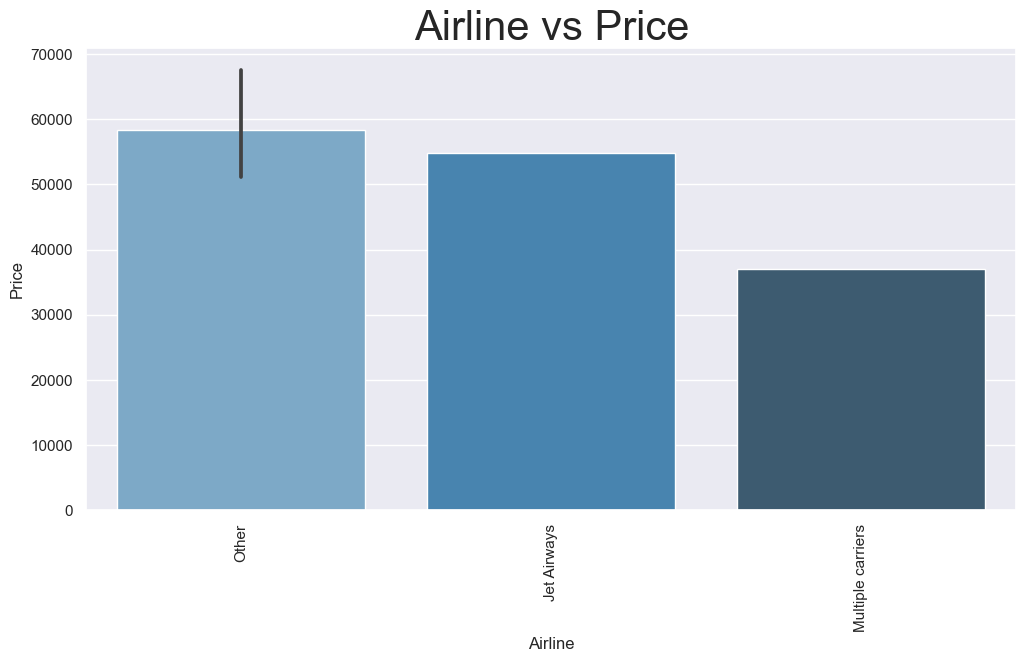

In [41]:
#visualization of the top 10 flights with the highest fare
plt.figure(figsize=(12,6))
sns.barplot(top_10['Airline'], top_10['Price'], palette='Blues_d')
plt.title('Airline vs Price', size=30)
plt.xticks(rotation=90)
plt.show()


c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


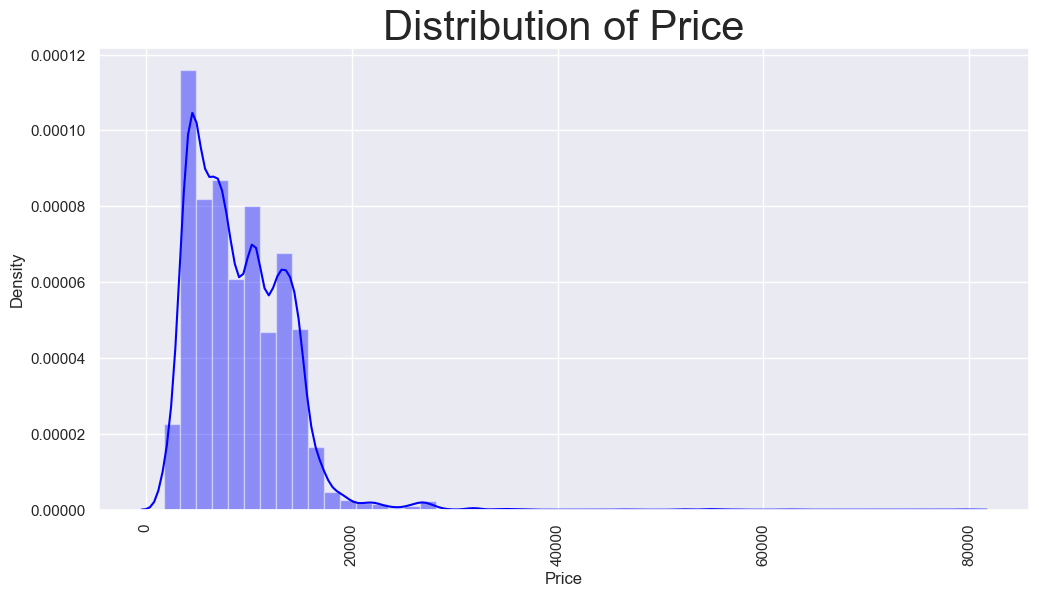

In [42]:
#analysis of the volatility of ticket prices
plt.figure(figsize=(12,6))
sns.distplot(df['Price'], color='blue')
plt.title('Distribution of Price', size=30)
plt.xticks(rotation=90)
plt.show()

### INSIGHT EDA

### MODELING

tạo các cột X và y cho tập dữ liệu huấn luyện trong khi cột y cho tập dữ liệu để dự đoán sẽ được tạo bởi mô hình của chúng tôi trong bước cuối cùng


In [43]:
#drop Day_of_Week since it's not useful
df.drop(labels = 'Day_of_Week', axis = 1, inplace = True)

In [44]:
#Label encode and hot encode categorical columns'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Airline'] = le.fit_transform(df['Airline'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Additional_Info'] = le.fit_transform(df['Additional_Info'])
df['Route'] = le.fit_transform(df['Route'])
df['Source'] = le.fit_transform(df['Source'])
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,3,0,2,18,0,7,3897,1,24,3,170,22,20,1,10
1,1,3,0,84,2,7,7662,0,1,5,445,5,50,13,15
2,4,2,1,118,2,7,13882,1,9,6,1140,9,25,4,25
3,3,3,0,91,1,7,6218,1,12,5,325,18,5,23,30
4,3,0,2,29,1,7,13302,0,1,3,285,16,50,21,35


In [45]:
# Creat X and y columns for training dataset while y column for dataset to predict will  be generated by our model in final step
X = df.drop(['Price'], axis=1)
y = df['Price']
X.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,3,0,2,18,0,7,1,24,3,170,22,20,1,10
1,1,3,0,84,2,7,0,1,5,445,5,50,13,15
2,4,2,1,118,2,7,1,9,6,1140,9,25,4,25
3,3,3,0,91,1,7,1,12,5,325,18,5,23,30
4,3,0,2,29,1,7,0,1,3,285,16,50,21,35


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Airline              10462 non-null  int32
 1   Source               10462 non-null  int32
 2   Destination          10462 non-null  int32
 3   Route                10462 non-null  int32
 4   Total_Stops          10462 non-null  int32
 5   Additional_Info      10462 non-null  int32
 6   isWeekend            10462 non-null  int32
 7   Day_Of_Journey       10462 non-null  int64
 8   Month_of_Journey     10462 non-null  int64
 9   Duration_minutes     10462 non-null  int64
 10  Depart_Time_Hour     10462 non-null  int64
 11  Depart_Time_Minutes  10462 non-null  int64
 12  Arr_Time_Hour        10462 non-null  int64
 13  Arr_Time_Minutes     10462 non-null  int64
dtypes: int32(7), int64(7)
memory usage: 939.9 KB


In [47]:
# Check the skew of all numerical features
from scipy.stats import skew
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 15 skewed numerical features to Box Cox transform


In [48]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
cols = list(X.columns)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns = cols)

X.head()
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

X = scaler.transform(X)
X = pd.DataFrame(X, columns = cols)
X.head()


There are 15 skewed numerical features to Box Cox transform


,Airline,Source,Destination,Route,Total_Stops,Additional_Info,isWeekend,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,-2.116063,-3.035159,-0.364484,-2.065615,-3.053276,-7.271132,2.760853,-1.443089,-5.296316,-1.259699,-1.888598,-1.309559,-2.216520,-1.545494
1,-2.660005,-0.903322,-2.279419,-2.016629,1.530071,-7.271132,-2.060442,-1.763907,-3.819546,-1.258602,-2.406923,-1.224812,-1.961169,-1.527283
2,-1.844092,-1.613935,-1.321952,-1.991393,1.530071,-7.271132,2.760853,-1.652318,-3.081161,-1.255829,-2.284964,-1.295434,-2.152683,-1.490860
3,-2.116063,-0.903322,-2.279419,-2.011433,-0.761603,-7.271132,2.760853,-1.610472,-3.819546,-1.259081,-2.010557,-1.351932,-1.748376,-1.472648
4,-2.116063,-3.035159,-0.364484,-2.057451,-0.761603,-7.271132,-2.060442,-1.763907,-5.296316,-1.259240,-2.071536,-1.224812,-1.790935,-1.454437


In [49]:
#Check shape of all three to verify that merge was done properly in above step
print(X.shape)

print(y.shape)

(10462, 14)
(10462,)


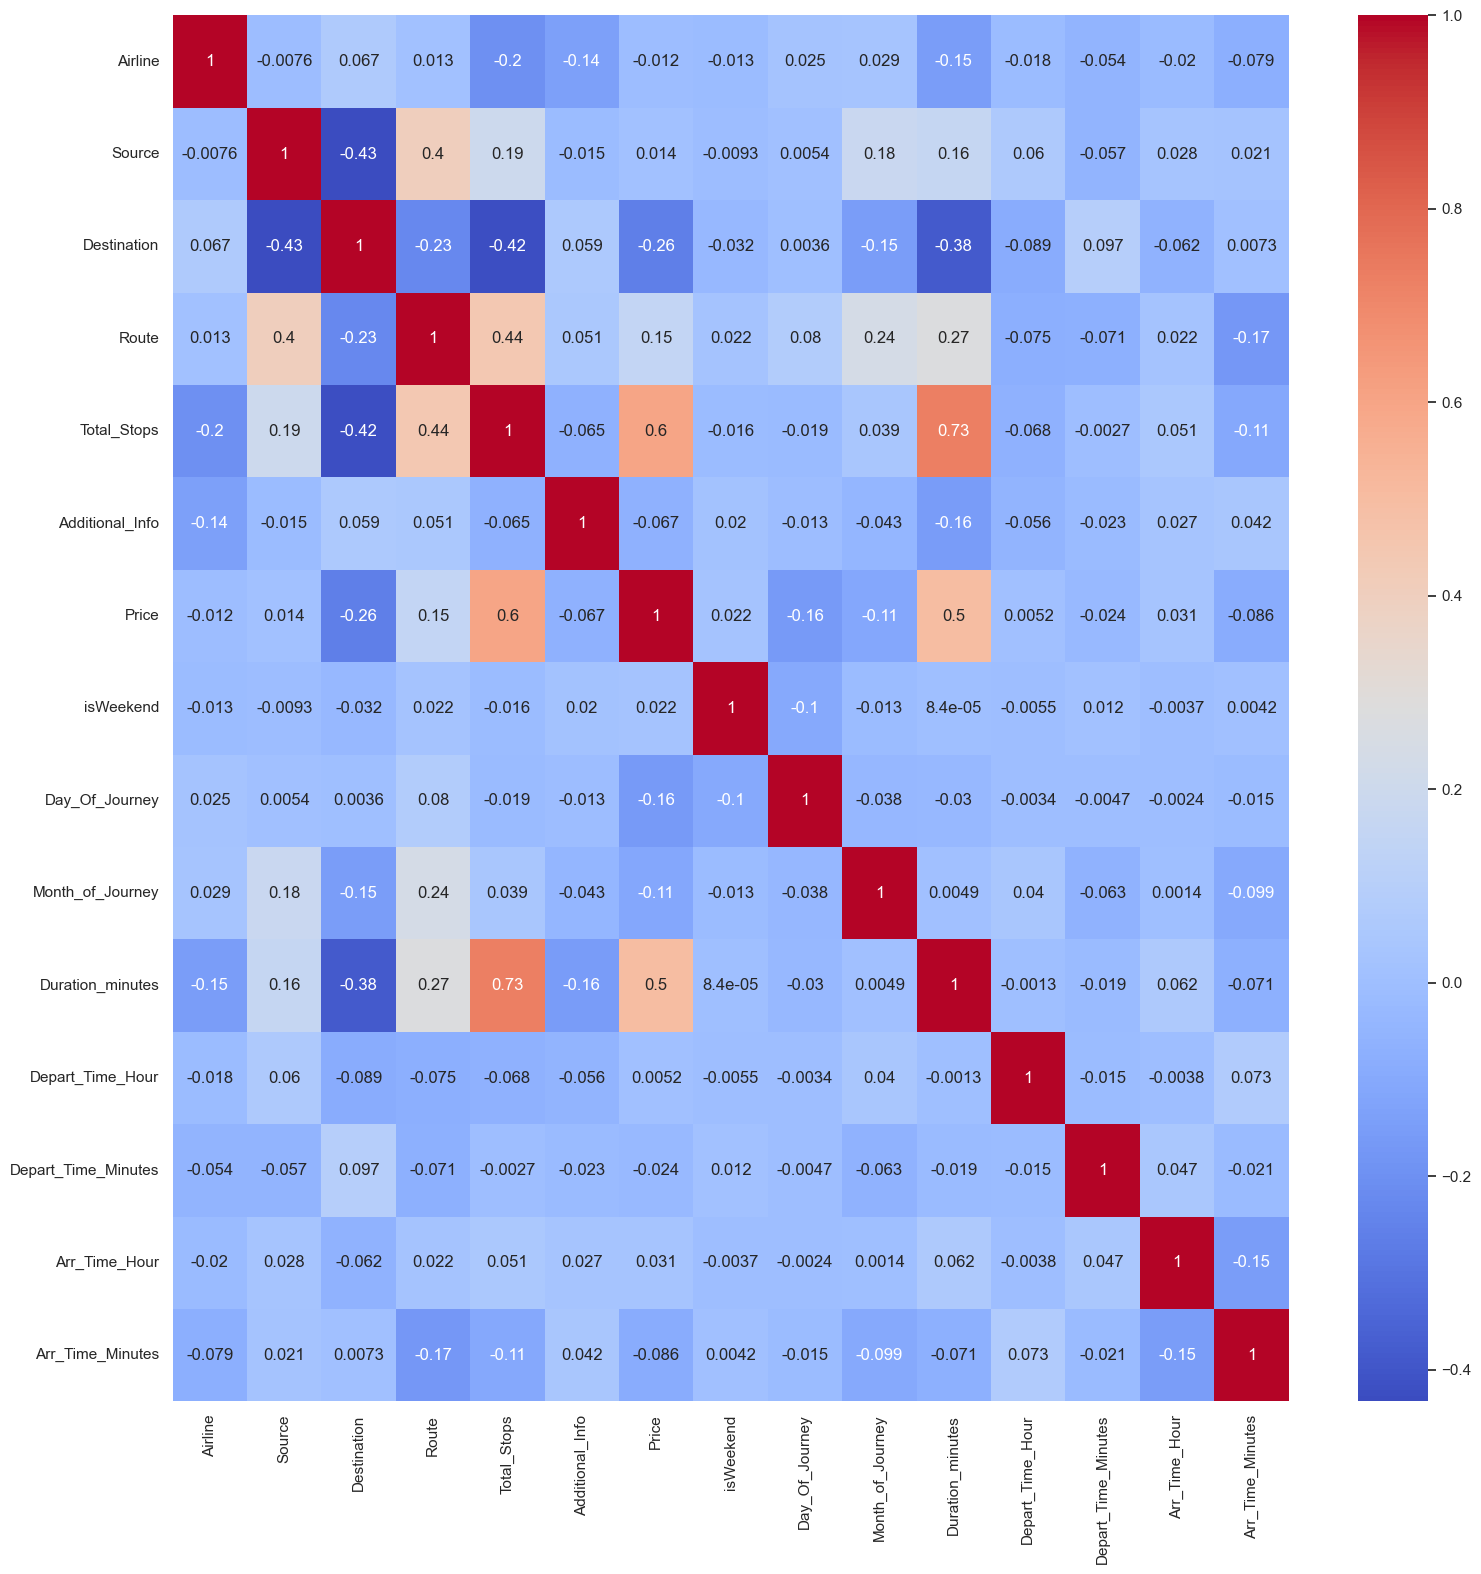

In [50]:
plt.figure(figsize = (18,18))

sns.heatmap(df.corr(),annot= True, cmap = "coolwarm")

plt.show()

[0.15623153 0.0173749  0.02611365 0.06670777 0.27005005 0.05978163
 0.01728594 0.11063934 0.05419167 0.13217132 0.02117079 0.02342938
 0.02687658 0.01797546]


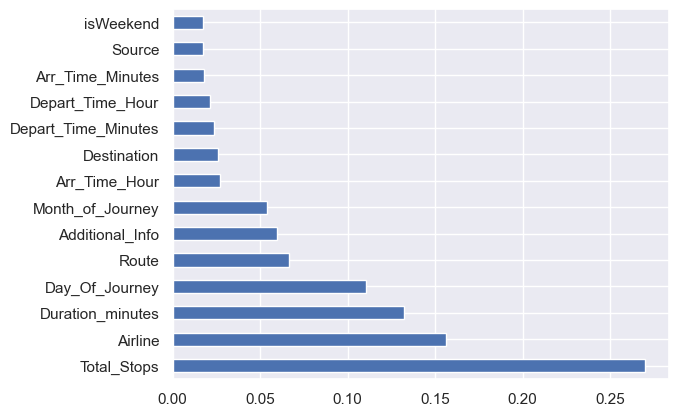

In [51]:
from sklearn.ensemble import  ExtraTreesRegressor
# getting feature importance to the target variable "Price".
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [52]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)



In [53]:
from sklearn import metrics
import numpy as np
from sklearn.metrics import mean_squared_log_error
# Creat a function to print accuracy metrics which can be used to get accuracy metrics of all models in upcoming steps
def print_accuracy_metrics(y_test, y_pred, X_test, model):
 print('R Squared(Accuracy)', metrics.r2_score(y_test, y_pred))   
 print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
 print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
 print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
 print('Root Mean Squared Log Error',np.sqrt(mean_squared_log_error( y_test, y_pred )))

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [55]:
def RandomForestRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_metrics(y_test, y_pred, X_test, rf))
    return rf
randomForestModel = RandomForestRegressorModel(X,y)


R Squared(Accuracy) 0.8913063166112059
Mean Absolute Error: 672.4243508851772
Mean Squared Error: 2257414.5342620197
Root Mean Squared Error: 1502.469478645746
Root Mean Squared Log Error 0.1370287814573628
None


In [56]:
# get feature importances from a model and plot them
def plotFeatureImportances(model):
    #first print all features importances in descending order
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)
    # Next plot feature importances to get idea about where the curve breaks
    # in the graph i.e. select top appropriate features
    features = X.columns.tolist()
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

                     importance
Duration_minutes       0.450628
Airline                0.118063
Day_Of_Journey         0.104049
Additional_Info        0.065688
Route                  0.063794
Total_Stops            0.045955
Month_of_Journey       0.045930
Depart_Time_Hour       0.025938
Arr_Time_Hour          0.022371
Depart_Time_Minutes    0.018935
Arr_Time_Minutes       0.014760
Destination            0.011112
isWeekend              0.006487
Source                 0.006290


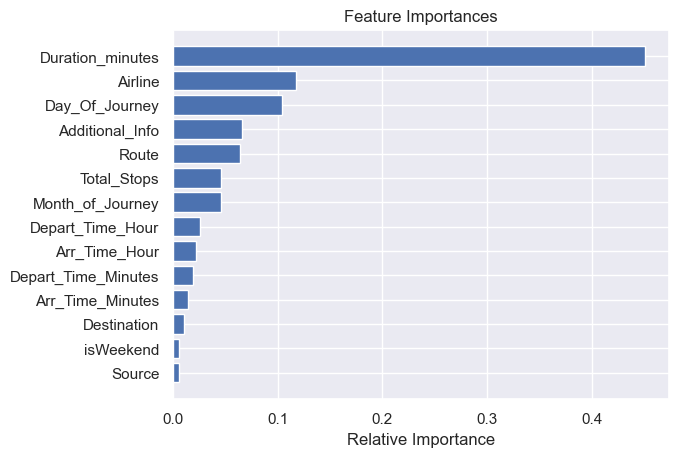

In [57]:
plotFeatureImportances(randomForestModel)

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


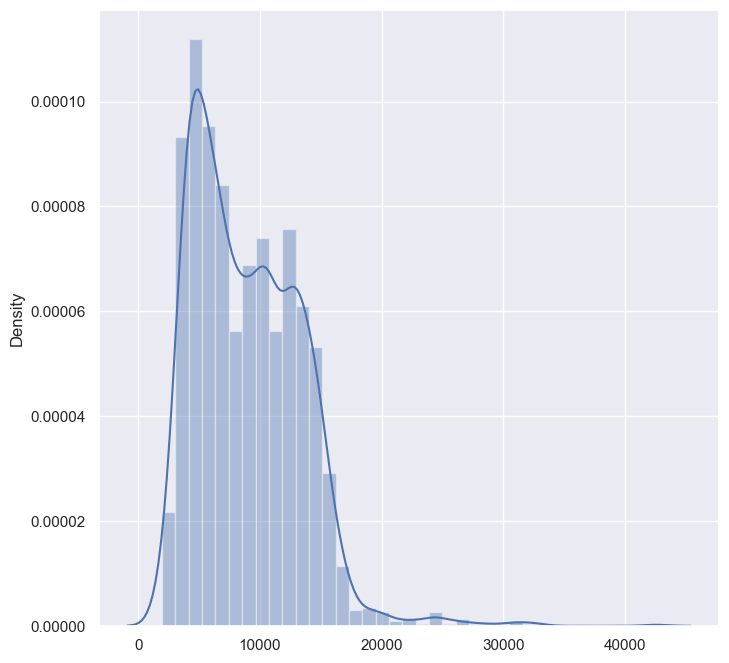

In [58]:
#use randomforest to predict airfare in next step after feauter importance
y_pred = randomForestModel.predict(X_test)
y_pred
#visualize the prediction
plt.figure(figsize = (8,8))
sns.distplot(y_pred)
plt.show()

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


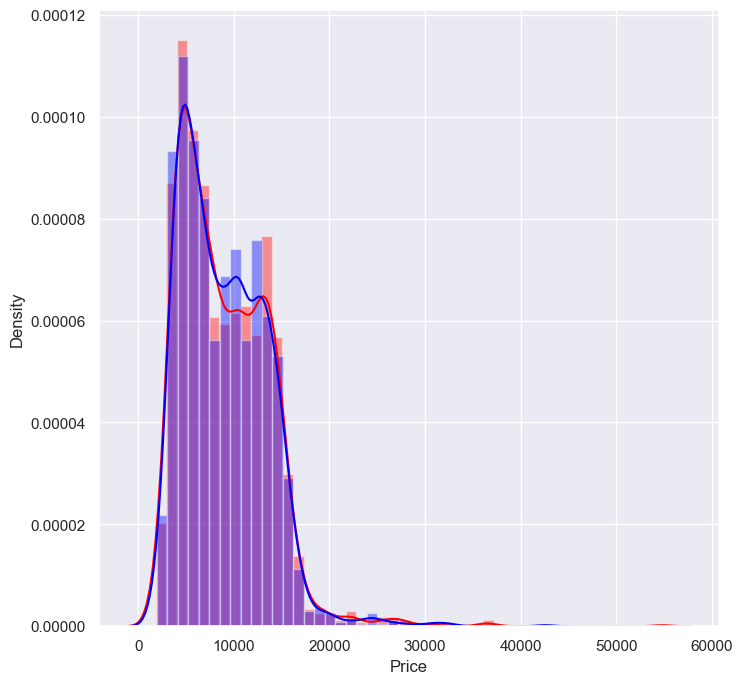

In [59]:
#compare the actual price with predicted price by random forest
plt.figure(figsize = (8,8))
sns.distplot(y_test, color = 'red')
sns.distplot(y_pred, color = 'blue')
plt.show()


In [60]:
pip install xgboost 

Note: you may need to restart the kernel to use updated packages.


R Squared(Accuracy) 0.8992831255713692
Mean Absolute Error: 740.5132990141665
Mean Squared Error: 2091747.460313535
Root Mean Squared Error: 1446.2874749902023
Root Mean Squared Log Error 0.13585881927440518
None
                     importance
Total_Stops            0.205778
Duration_minutes       0.199776
Destination            0.155813
Additional_Info        0.112760
Airline                0.112122
Month_of_Journey       0.048115
Day_Of_Journey         0.038491
Source                 0.028021
Route                  0.027380
Arr_Time_Hour          0.025600
Depart_Time_Minutes    0.013295
Depart_Time_Hour       0.012636
Arr_Time_Minutes       0.012058
isWeekend              0.008156


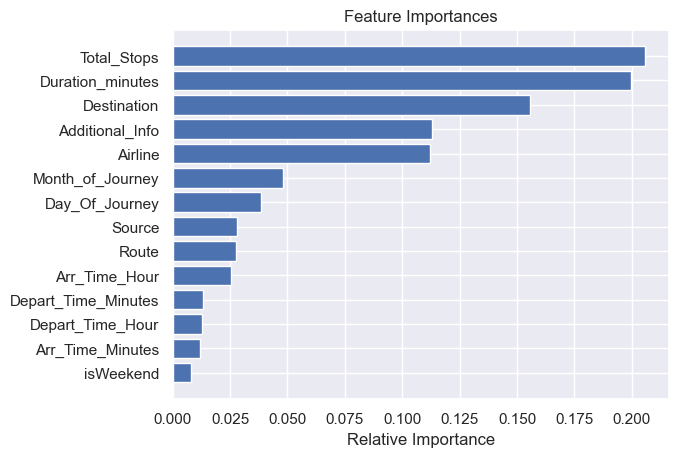

array([11057.768,  6425.87 , 14118.216, ..., 10824.48 , 12059.893,
       14051.622], dtype=float32)

In [61]:
# select features using XGboost
from xgboost import XGBRegressor
def XGBoostModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(print_accuracy_metrics(y_test, y_pred, X_test, xgb))
    return xgb
xgbModel = XGBoostModel(X,y)
## get feature importances from a model and plot them
plotFeatureImportances(xgbModel)
#use xgboost to predict airfare in next step after feauter importance
y_pred = xgbModel.predict(X_test)
y_pred

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


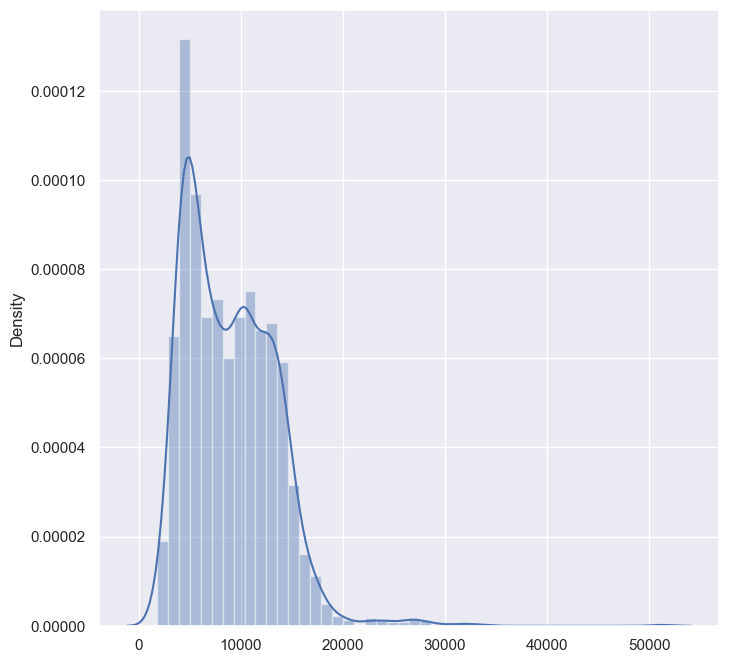

In [62]:
#visualize the prediction by xgboost
plt.figure(figsize = (8,8))
sns.distplot(y_pred)
plt.show()


c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


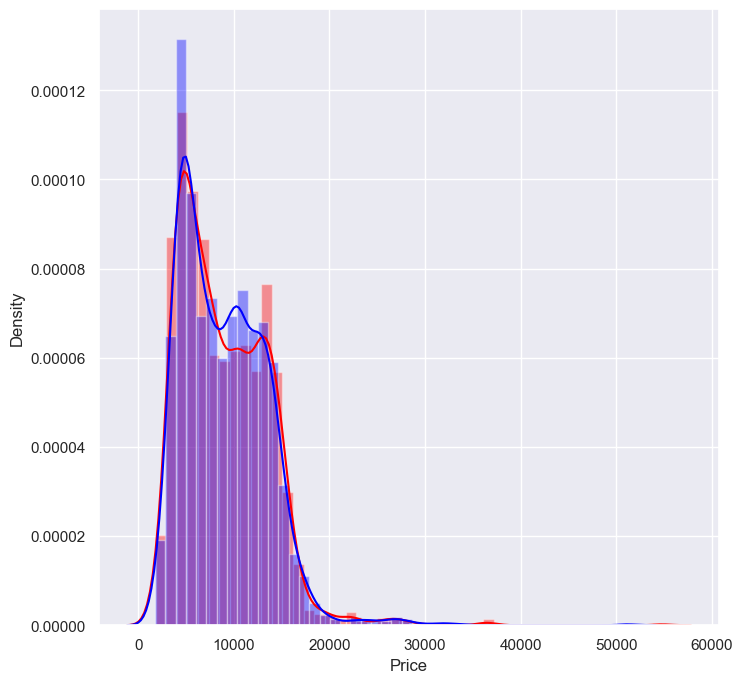

In [63]:
#compare the actual price with predicted price by xgboost
plt.figure(figsize = (8,8))
sns.distplot(y_test, color = 'red')
sns.distplot(y_pred, color = 'blue')
plt.show()


R Squared(Accuracy) 0.833451282254898
Mean Absolute Error: 1218.2204924154937
Mean Squared Error: 3458982.016053904
Root Mean Squared Error: 1859.8338678639832
Root Mean Squared Log Error 0.18895267184733014
None
                     importance
Duration_minutes       0.490058
Airline                0.141230
Day_Of_Journey         0.120124
Additional_Info        0.072989
Route                  0.055339
Total_Stops            0.050940
Month_of_Journey       0.047429
Arr_Time_Hour          0.005806
Source                 0.004225
Depart_Time_Minutes    0.003662
Depart_Time_Hour       0.002489
Destination            0.002462
Arr_Time_Minutes       0.002078
isWeekend              0.001169


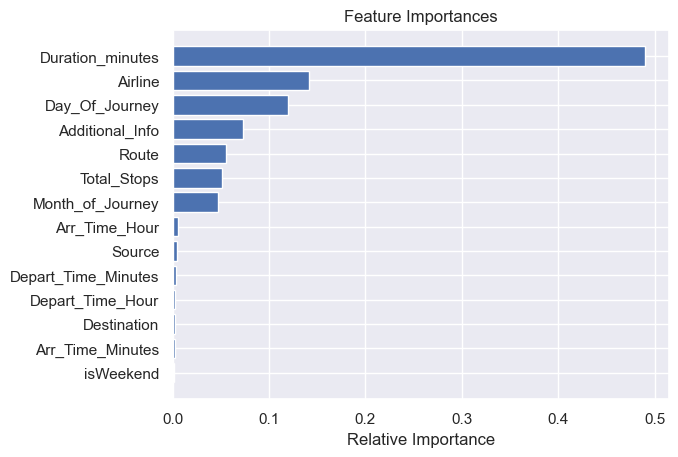

array([ 9818.89771883,  7747.73349301, 13428.38747851, ...,
       10855.56943657, 12791.07497782, 15269.79369725])

In [64]:
from sklearn.ensemble import GradientBoostingRegressor 
def GradientBoostingRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = GradientBoostingRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_metrics(y_test, y_pred, X_test, rf))
    return rf
gradientBoostingRegressorModel =  GradientBoostingRegressorModel (X,y)
## get feature importances from a model and plot them
plotFeatureImportances(gradientBoostingRegressorModel)
#use gradientboosting to predict airfare in next step after feauter importance
y_pred = gradientBoostingRegressorModel.predict(X_test)
y_pred




c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


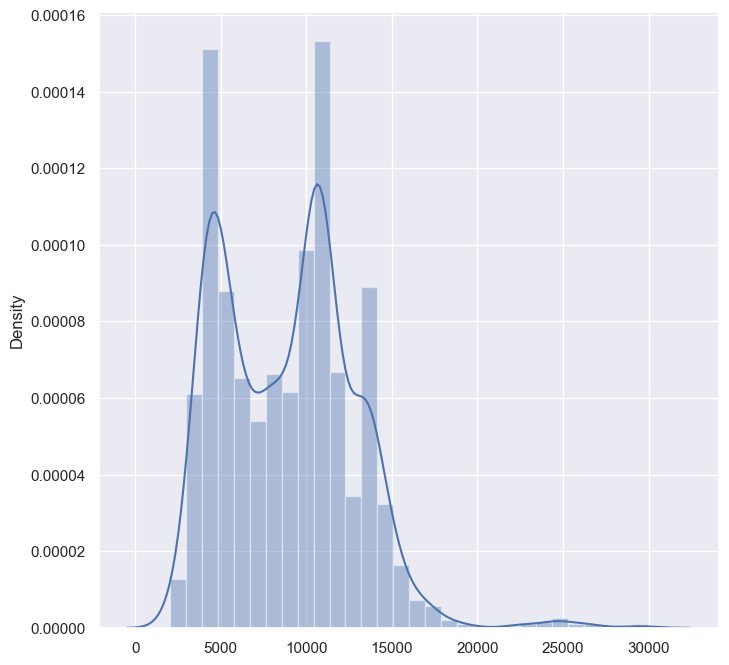

In [65]:
#visualize the prediction by gradientboosting
plt.figure(figsize = (8,8))
sns.distplot(y_pred)
plt.show()


In [66]:
df.columns 

Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info', 'Price', 'isWeekend', 'Day_Of_Journey',
       'Month_of_Journey', 'Duration_minutes', 'Depart_Time_Hour',
       'Depart_Time_Minutes', 'Arr_Time_Hour', 'Arr_Time_Minutes'],
      dtype='object')

c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


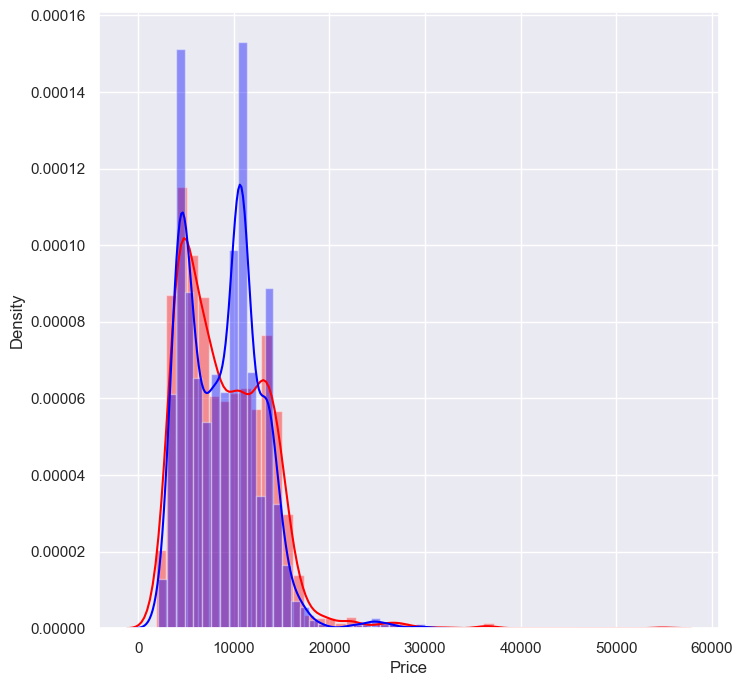

In [67]:
#compare the actual price with predicted price by gradientboosting
plt.figure(figsize = (8,8)) 
sns.distplot(y_test, color = 'red')
sns.distplot(y_pred, color = 'blue')
plt.show()


c:\Users\lethi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


R Squared(Accuracy) 0.3584999753269572
Mean Absolute Error: 2653.9825664625705
Mean Squared Error: 13323050.92878715
Root Mean Squared Error: 3650.0754689166565
Root Mean Squared Log Error 0.38793114314792765
None


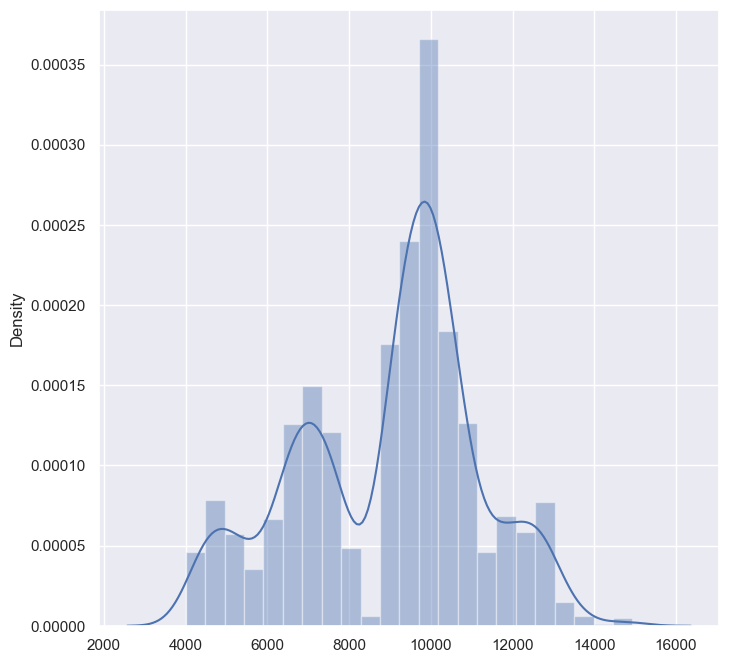

In [68]:
# use Neural Networks to predict airfare 
from sklearn.neural_network import MLPRegressor
def MLPRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = MLPRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_metrics(y_test, y_pred, X_test, rf))
    return rf
mlpRegressorModel =  MLPRegressorModel (X,y)
#use neural networks to predict airfare in next step after feauter importance
y_pred = mlpRegressorModel.predict(X_test)
y_pred
#AttributeError: 'MLPRegressor' object has no attribute 'feature_importances_'
#visualize the prediction by neural networks
plt.figure(figsize = (8,8))
sns.distplot(y_pred)
plt.show()


c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lethi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


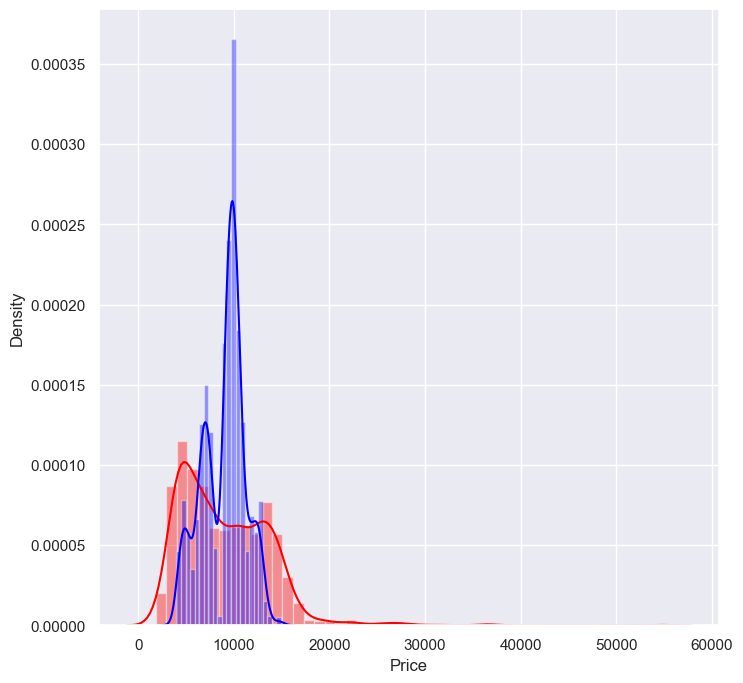

In [69]:
#compare the actual price with predicted price by neural networks
plt.figure(figsize = (8,8))
sns.distplot(y_test, color = 'red')
sns.distplot(y_pred, color = 'blue')
plt.show()
